In [83]:
%%capture
! pip install pytorch-lightning
#! pip install pytorch-lightning-bolts==0.2.5rc1
!pip install --quiet "torchinfo" "lightning-bolts"

# Full Implementation
So, the full implementation is as follows.

In [84]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class ConditionalVAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, num_classes=10):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        self.num_classes = num_classes

        # class embeddings
        #self.class_embeddings = nn.Sequential(nn.Linear(num_classes, enc_out_dim),
        #                                      nn.ReLU())
        self.class_embeddings = nn.Embedding(num_classes, enc_out_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self,x,label):
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)

        # Add label embedding to the image embeddings
        c = self.class_embeddings(label)
        x_encoded = x_encoded + c

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)
        return x_hat, mu, std, z


    def training_step(self, batch, batch_idx):
        x, label = batch

        # get the x_hat
        x_hat, mu, std, z = self(x, label)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [85]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

**Inference after every 5 epochs**

In [118]:
from matplotlib.pyplot import imshow, figure
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from torchvision.utils import make_grid
import numpy as np
figure(figsize=(8, 3), dpi=300)


def generate_images(model, image, label, num_images=32):
    predictions = []
    with torch.no_grad():
        for cnt in range(num_images):
            this_pred,_,_,_ = model(image, label)
            # UNDO DATA NORMALIZATION
            normalize = cifar10_normalization()
            mean, std = np.array(normalize.mean), np.array(normalize.std)
            this_pred = this_pred.squeeze().permute(1, 2, 0).numpy()*std + mean
            predictions.append(this_pred.transpose())

    img = make_grid(torch.tensor(predictions)).permute(1, 2, 0)
    # PLOT IMAGES
    imshow(img);


<Figure size 2400x900 with 0 Axes>

In [92]:
from pytorch_lightning.callbacks import Callback

class PeriodicInference(Callback):
    def __init__(self, data_module):
        super().__init__()
        self.data_module = data_module

    def on_train_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch +1) % 10 == 0:
            # plot SAMPLE IMAGES
            test_dl = self.data_module.val_dataloader()
            images, labels = next(iter(test_dl))
            one_image = images[0].unsqueeze(0)
            one_label = labels[0].unsqueeze(0)
            generate_images(trainer.model, one_image, one_label)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we train!

In [88]:
pl.seed_everything(1234)

cond_vae = ConditionalVAE()
trainer = pl.Trainer(gpus=1,
                     max_epochs=40,
                     callbacks=[PeriodicInference(data_module=datamodule)])
trainer.fit(cond_vae, datamodule)

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
<ipython-input-84-f7a8e8ba0cd9>:17: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/usr/local/lib/python3.10/dist-pa

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type          | Params
---------------------------------------------------
0 | encoder          | ResNetEncoder | 11.2 M
1 | decoder          | ResNetDecoder | 8.6 M 
2 | class_embeddings | Embedding     | 5.1 K 
3 | fc_mu            | Linear        | 131 K 
4 | fc_var           | Linear        | 131 K 
---------------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.249    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

AttributeError: ignored

## Plot an image

32
torch.Size([32, 3, 32, 32])


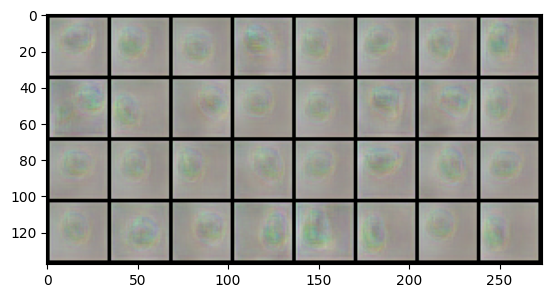

In [ ]:
imgs, labels = next(iter(datamodule.val_dataloader()))
one_image = imgs[0].unsqueeze(0)
one_label = labels[0].unsqueeze(0)
generate_images(vae, one_image, one_label, num_images=32)